# Real Time Air Quality Analysis and Forcasting

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import requests

In [2]:
# Data Anaysis and Visualization
# Data Gathering

In [3]:
url = "https://api.openaq.org/v1/latest"


response = requests.get(url)

print(response.status_code) 

if response.status_code == 200:
    data = response.json()  

    results = data['results']

    df = pd.json_normalize(results, 'measurements', ['location', 'city', 'country'], record_prefix='measurement_')

    df.to_csv('air_quality_data.csv', index=False)
    print("Data saved to air_quality_data.csv")

    df_loaded = pd.read_csv('air_quality_data.csv')

    print(df_loaded.head())
else:
    print(f"Error: {response.status_code}")

200
Data saved to air_quality_data.csv
  measurement_parameter  measurement_value    measurement_lastUpdated  \
0                  pm25            15.7000  2024-06-30T23:00:00+00:00   
1                   no2            29.2000  2024-06-30T23:00:00+00:00   
2                    o3            40.4725  2018-10-13T21:00:00+00:00   
3                  pm10            42.8000  2024-06-30T23:00:00+00:00   
4                   no2            15.0000  2024-06-30T23:00:00+00:00   

  measurement_unit measurement_sourceName  measurement_averagingPeriod.value  \
0            µg/m³              Stockholm                               3600   
1            µg/m³              Stockholm                               3600   
2            µg/m³              Stockholm                               3600   
3            µg/m³              Stockholm                               3600   
4            µg/m³              Stockholm                               3600   

  measurement_averagingPeriod.unit    loc

In [4]:
df

,measurement_parameter,measurement_value,measurement_lastUpdated,measurement_unit,measurement_sourceName,measurement_averagingPeriod.value,measurement_averagingPeriod.unit,location,city,country
0,pm25,15.7000,2024-06-30T23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
1,no2,29.2000,2024-06-30T23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
2,o3,40.4725,2018-10-13T21:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
3,pm10,42.8000,2024-06-30T23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
4,no2,15.0000,2024-06-30T23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Sveavägen,Stockholm,SE
...,...,...,...,...,...,...,...,...,...,...
272,no2,3.0000,2024-06-09T14:00:00+00:00,µg/m³,DEFRA,3600,seconds,Barnsley Gawber,Barnsley,GB
273,pm25,5.0000,2024-06-09T14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Barnsley Gawber,Barnsley,GB
274,pm10,10.0000,2024-06-09T14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Barnsley Gawber,Barnsley,GB
275,o3,69.0000,2024-06-09T14:00:00+00:00,µg/m³,DEFRA,28800,seconds,Barnsley Gawber,Barnsley,GB


In [5]:
# Data Cleaning

In [6]:
# Check null Values
df.isnull().sum().sum()

0

In [7]:
# Drop rows with having missing values
df.dropna(inplace=True)

In [8]:
# Check Duplicates
df.duplicated().sum()

0

In [9]:
# Summary Statistics
df.describe()

,measurement_value,measurement_averagingPeriod.value
count,277.000000,277.000000
mean,16.795504,26473.646209
std,78.450986,35844.661722
min,-999.000000,900.000000
25%,4.000000,900.000000
50%,8.000000,3600.000000
75%,21.000000,86400.000000
max,610.000000,86400.000000


In [10]:
# Convert Meaasurement_lastupdate to datetime
df['measurement_lastUpdated'] = pd.to_datetime(df['measurement_lastUpdated'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   measurement_parameter              277 non-null    object             
 1   measurement_value                  277 non-null    float64            
 2   measurement_lastUpdated            277 non-null    datetime64[ns, UTC]
 3   measurement_unit                   277 non-null    object             
 4   measurement_sourceName             277 non-null    object             
 5   measurement_averagingPeriod.value  277 non-null    int64              
 6   measurement_averagingPeriod.unit   277 non-null    object             
 7   location                           277 non-null    object             
 8   city                               277 non-null    object             
 9   country                            277 non-null    obj

In [12]:
# Filter data for a specific pollutant (e.g., PM2.5)
pm25_data = df[df['measurement_parameter'] == 'pm25']

In [13]:
pm25_data

,measurement_parameter,measurement_value,measurement_lastUpdated,measurement_unit,measurement_sourceName,measurement_averagingPeriod.value,measurement_averagingPeriod.unit,location,city,country
0,pm25,15.7,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
6,pm25,0.0,2023-01-11 18:00:00+00:00,µg/m³,Stockholm,3600,seconds,Sveavägen,Stockholm,SE
8,pm25,14.4,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Sankt Eriksgatan,Stockholm,SE
10,pm25,8.7,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,"Hamngatan, Linköping",Stockholm,SE
12,pm25,14.4,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,"Kungsgatan, Uppsala",Uppsala,SE
...,...,...,...,...,...,...,...,...,...,...
251,pm25,6.0,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Wigan Centre,Wigan,GB
259,pm25,4.0,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Sibton,Sibton,GB
261,pm25,6.0,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Bournemouth,Bournemouth,GB
268,pm25,8.0,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Manchester Piccadilly,Manchester,GB


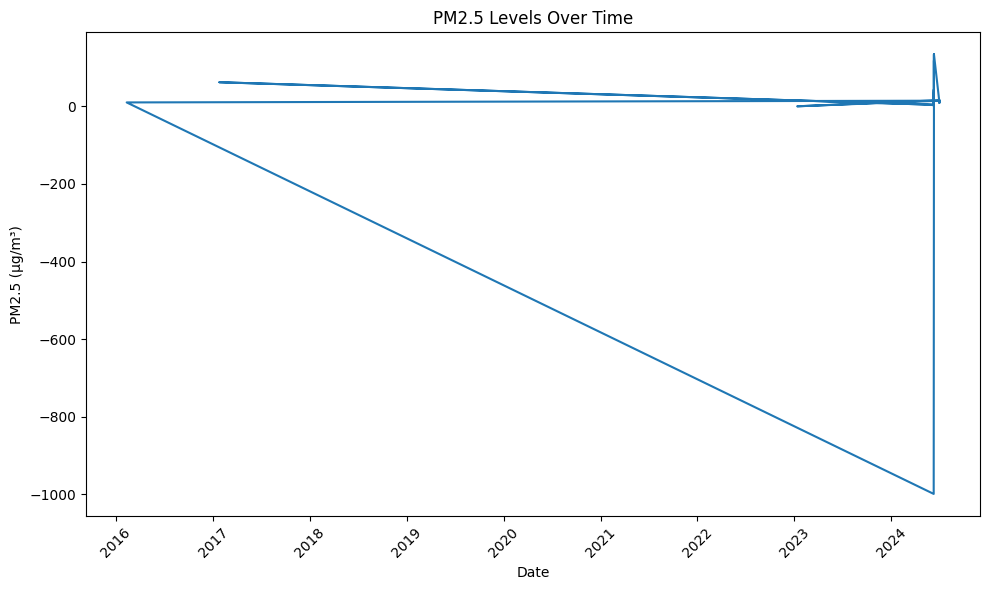

In [14]:
# Plot PM2.5 levels over time
plt.figure(figsize=(10, 6))
plt.plot(pm25_data['measurement_lastUpdated'], pm25_data['measurement_value'])
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

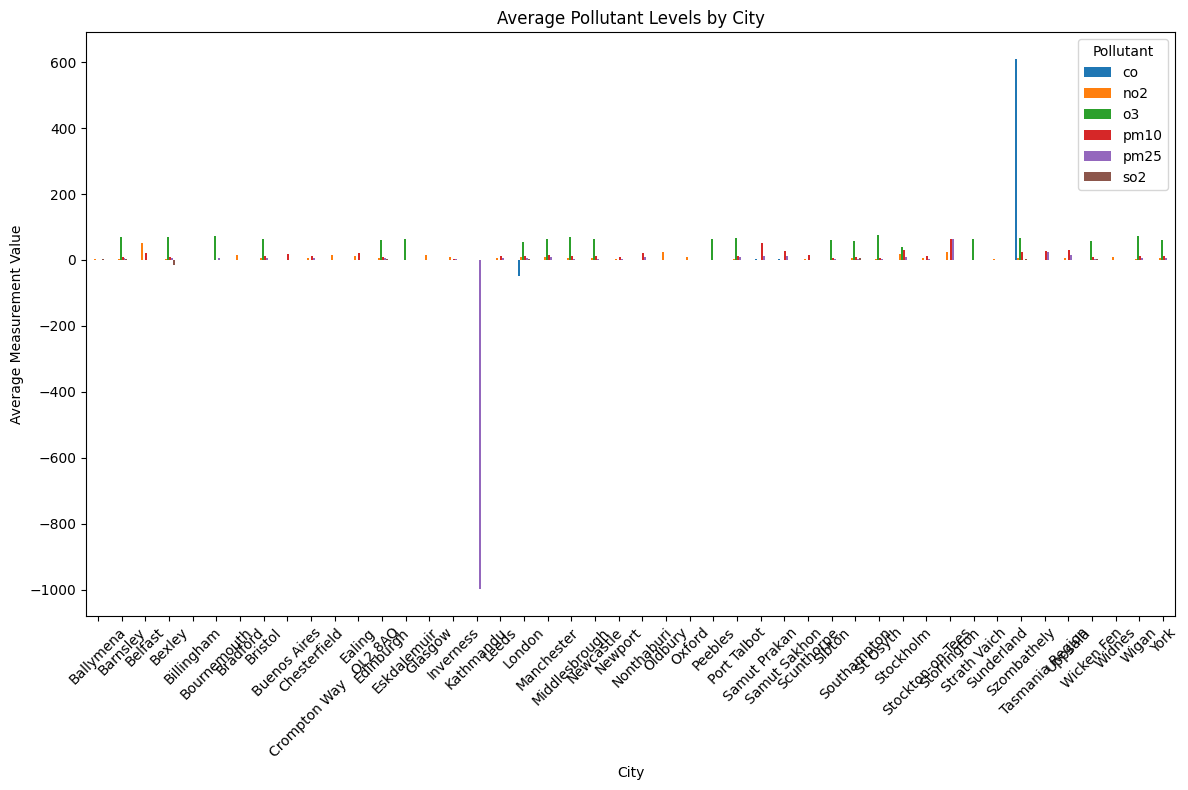

In [15]:
# Plot the average pollutant levels by city
avg_pollutant_by_city = df.groupby(['city', 'measurement_parameter'])['measurement_value'].mean().unstack()
avg_pollutant_by_city.plot(kind='bar', figsize=(12, 8))
plt.title('Average Pollutant Levels by City')
plt.xlabel('City')
plt.ylabel('Average Measurement Value')
plt.legend(title='Pollutant')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Correlation Analysis

In [17]:
relevant_columns = df[['measurement_value', 'measurement_averagingPeriod.value']]

# Compute the correlation matrix
correlation_matrix = relevant_columns.corr()

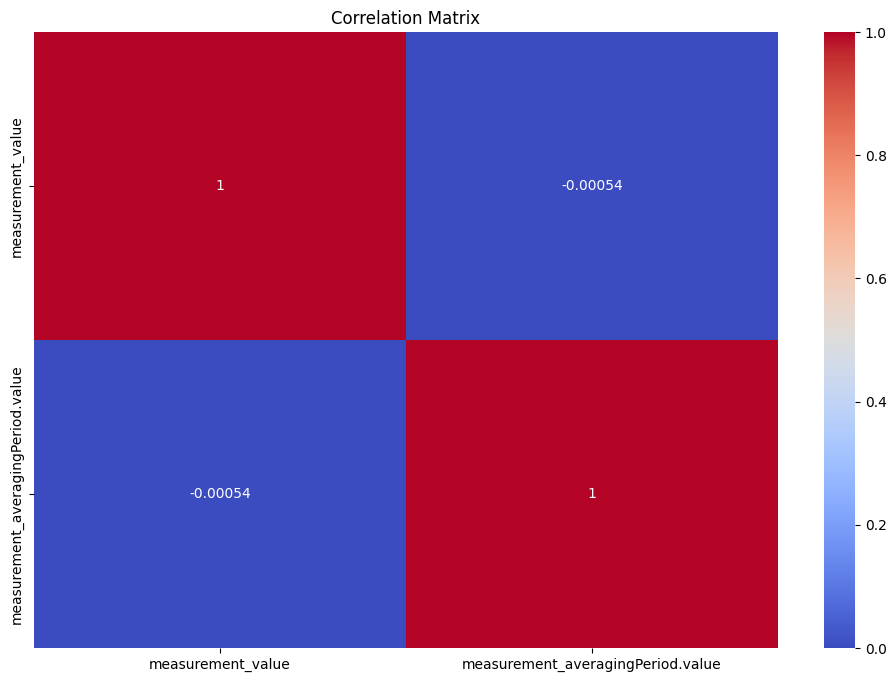

In [18]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

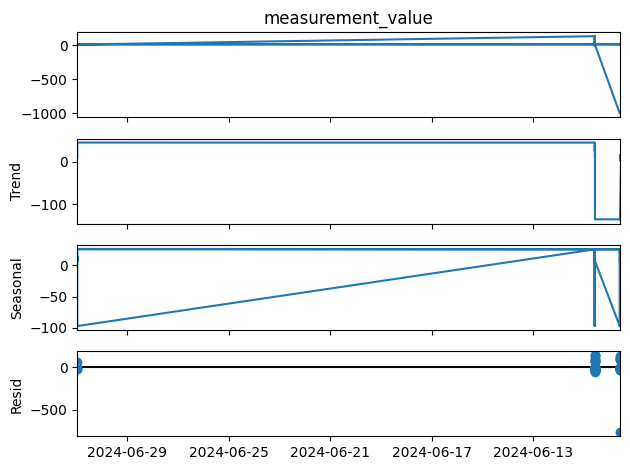

In [19]:
# Time series Analysis
# Decompose the time series for PM2.5 with a smaller period
pm25_time_series = pm25_data.set_index('measurement_lastUpdated')['measurement_value']

# Choose a smaller period, e.g., weekly seasonality (7 days)
period = 7

# Perform the decomposition
decomposition = seasonal_decompose(pm25_time_series, model='additive', period=period)

# Plot the decomposition
decomposition.plot()
plt.show()

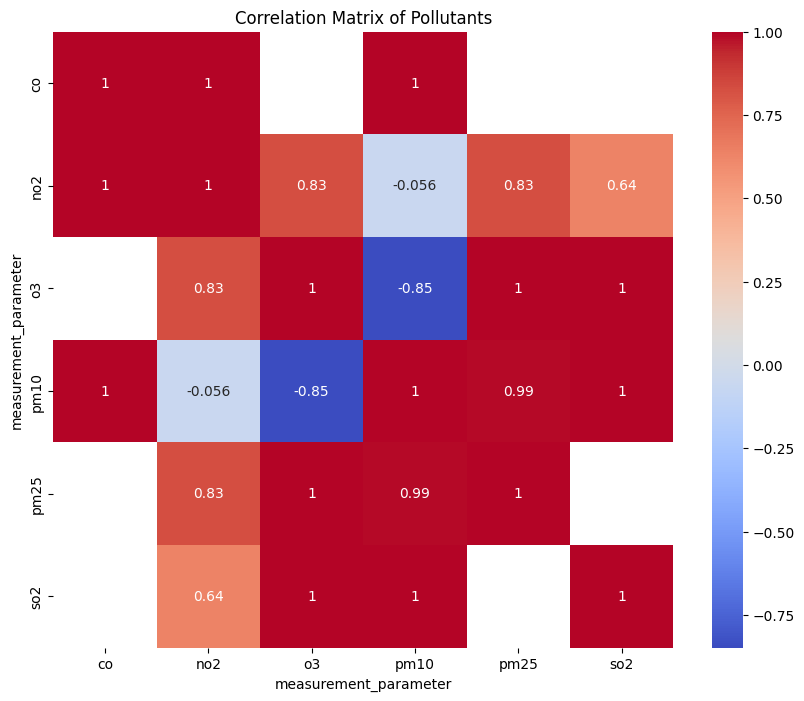

In [22]:
#  Correlation Analysis: Pearson correlation between pollutants
pollutants = df.pivot_table(index='measurement_lastUpdated', columns='measurement_parameter', values='measurement_value')
correlation_matrix = pollutants.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Pollutants')
plt.show()

In [23]:
df

,measurement_parameter,measurement_value,measurement_lastUpdated,measurement_unit,measurement_sourceName,measurement_averagingPeriod.value,measurement_averagingPeriod.unit,location,city,country
0,pm25,15.7000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
1,no2,29.2000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
2,o3,40.4725,2018-10-13 21:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
3,pm10,42.8000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
4,no2,15.0000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Sveavägen,Stockholm,SE
...,...,...,...,...,...,...,...,...,...,...
272,no2,3.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,3600,seconds,Barnsley Gawber,Barnsley,GB
273,pm25,5.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Barnsley Gawber,Barnsley,GB
274,pm10,10.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Barnsley Gawber,Barnsley,GB
275,o3,69.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,28800,seconds,Barnsley Gawber,Barnsley,GB


In [24]:
# Model Buidling

In [25]:
# Filter data for PM2.5 and NO2
pm25_data = df[df['measurement_parameter'] == 'pm25']
no2_data = df[df['measurement_parameter'] == 'no2']

In [26]:
# Merge PM2.5 and NO2 data on common columns
merged_data = pd.merge(pm25_data, no2_data, on=['location', 'city', 'country', 'measurement_lastUpdated'], suffixes=('_pm25', '_no2'))

In [27]:
# Define features and target variable
X = merged_data[['measurement_value_no2']]  # NO2 levels as predictor
y = merged_data['measurement_value_pm25'] 

In [28]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

In [31]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [32]:
print("mean square error", mse)
print("r2_score",r2)

mean square error 4.169013512767278
r2_score -0.052998258379364005


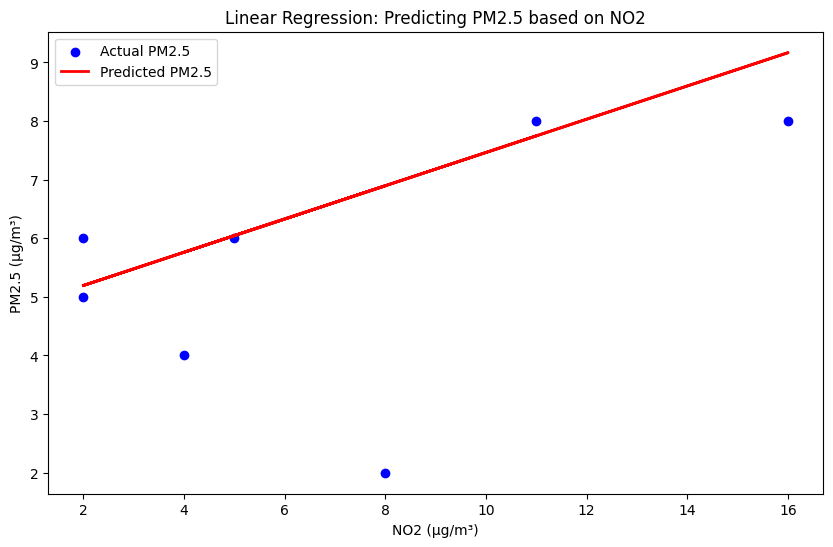

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual PM2.5')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted PM2.5')
plt.title('Linear Regression: Predicting PM2.5 based on NO2')
plt.xlabel('NO2 (µg/m³)')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

In [34]:
df.to_csv(r"C:\Users\hp\Downloads\AirQuality.csv")

In [35]:
df

,measurement_parameter,measurement_value,measurement_lastUpdated,measurement_unit,measurement_sourceName,measurement_averagingPeriod.value,measurement_averagingPeriod.unit,location,city,country
0,pm25,15.7000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
1,no2,29.2000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
2,o3,40.4725,2018-10-13 21:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
3,pm10,42.8000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Hornsgatan,Stockholm,SE
4,no2,15.0000,2024-06-30 23:00:00+00:00,µg/m³,Stockholm,3600,seconds,Sveavägen,Stockholm,SE
...,...,...,...,...,...,...,...,...,...,...
272,no2,3.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,3600,seconds,Barnsley Gawber,Barnsley,GB
273,pm25,5.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Barnsley Gawber,Barnsley,GB
274,pm10,10.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,86400,seconds,Barnsley Gawber,Barnsley,GB
275,o3,69.0000,2024-06-09 14:00:00+00:00,µg/m³,DEFRA,28800,seconds,Barnsley Gawber,Barnsley,GB


In [37]:
Lr=model.fit(X_train, y_train)

In [39]:
import pickle
pickle.dump(Lr,open("AAirqualityprediction.pkl","wb"))